# MLP for complete TF
In this case, we are going to predict the complete TF function

In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [2]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 1000
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(188, 256) (188,)


In [3]:
# Use only certain Vs
idx = np.random.choice(range(len(Vs_data)), 400)
TTF_values = TTF_data[idx]
Vs_values = Vs_data[idx]
print(TTF_values.shape, Vs_values.shape)

(400, 256) (400,)


In [4]:
# Normalize the data
def normalize_data(data, mean, std):
    return (data - mean) / std

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
mean_Vs = Vs_values.mean()
std_Vs = Vs_values.std()
mean_TTF = TTF_values.mean()
std_TTF = TTF_values.std()

Vs_values = normalize_data(Vs_values, mean_Vs, std_Vs)
TTF_values = normalize_data(TTF_values, mean_TTF, std_TTF)

In [5]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[idx] * np.ones(30)
        input_data = Vs
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx,:]
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [6]:
# Create dataset
dataset = TTFDataset(TTF_values, Vs_values)

# Create dataloader
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print("Number of samples: ", len(train_dataset), len(val_dataset), len(test_dataset))

# Create dataloader
i_batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))



Number of samples:  320 40 40
Number of batches:  2 1 1


In [7]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [8]:
# Define Transformer
class Transformer(nn.Module):
    def __init__(self, encoder_hidden_dim, encoder_hidden_size, decoder_hidden_dim, decoder_hidden_size, input_dim, output_dim, latent_dim):
        super(Transformer, self).__init__()

        self.encoder = MLP(input_dim, encoder_hidden_dim, encoder_hidden_size, latent_dim, batch_norm=True)
        self.decoder = MLP(latent_dim, decoder_hidden_dim, decoder_hidden_size, output_dim, batch_norm=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = Transformer(128, 5, 128, 5, 30, 256, 5)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([200, 30]) torch.Size([200, 256])
Loss:  tensor(1.2945, grad_fn=<MseLossBackward0>)


In [10]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [11]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 250 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

In [12]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [13]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model

Transformer(
  (encoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=30, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (out): Linear(in_features=128, out_features=5, bias=True)
  )
  (decoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=5, o

In [15]:
# Model
model = Transformer(128, 3, 128, 3, 30, 256, 50)

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [16]:
# Optimizer with momentum NAG
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.01, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.6, 0.6), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [17]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=2500)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Training:   0%|          | 3/10000 [00:01<47:31,  3.51epoch/s, EarlyStopping counter: 4 out of 2500]  

Epoch 0, Train Loss: 1.2586416006088257, Val Loss: 1.0109589099884033, LR: 0.009494661373947147


Training:   3%|▎         | 253/10000 [00:09<05:03, 32.09epoch/s, EarlyStopping counter: 5 out of 2500] 

Epoch 250, Train Loss: 0.43537649512290955, Val Loss: 0.4087049067020416, LR: 0.009792543922781564


Training:   5%|▌         | 506/10000 [00:17<05:28, 28.87epoch/s, EarlyStopping counter: 106 out of 2500]

Epoch 500, Train Loss: 0.5919952094554901, Val Loss: 0.7617377042770386, LR: 0.009616814306679343


Training:   8%|▊         | 753/10000 [00:25<05:22, 28.67epoch/s, EarlyStopping counter: 31 out of 2500] 

Epoch 750, Train Loss: 0.36773084104061127, Val Loss: 0.5824019908905029, LR: 0.009705684805101087


Training:  10%|█         | 1004/10000 [00:33<04:57, 30.24epoch/s, EarlyStopping counter: 186 out of 2500]

Epoch 1000, Train Loss: 0.3799402564764023, Val Loss: 0.3564339280128479, LR: 0.009818834437420234


Training:  13%|█▎        | 1254/10000 [00:42<04:44, 30.70epoch/s, EarlyStopping counter: 436 out of 2500]

Epoch 1250, Train Loss: 0.38704048097133636, Val Loss: 0.42477262020111084, LR: 0.009784476566308832


Training:  15%|█▌        | 1506/10000 [00:50<04:47, 29.58epoch/s, EarlyStopping counter: 687 out of 2500]

Epoch 1500, Train Loss: 0.40853865444660187, Val Loss: 0.33839723467826843, LR: 0.009827922647623308


Training:  18%|█▊        | 1754/10000 [00:59<04:33, 30.14epoch/s, EarlyStopping counter: 936 out of 2500]

Epoch 1750, Train Loss: 0.37581050395965576, Val Loss: 0.4631633162498474, LR: 0.009765228077279533


Training:  20%|██        | 2003/10000 [01:07<04:41, 28.44epoch/s, EarlyStopping counter: 129 out of 2500] 

Epoch 2000, Train Loss: 0.3360443711280823, Val Loss: 0.3942747712135315, LR: 0.009799794745148678


Training:  23%|██▎       | 2254/10000 [01:15<04:06, 31.44epoch/s, EarlyStopping counter: 1 out of 2500]  

Epoch 2250, Train Loss: 0.28932372480630875, Val Loss: 0.23889723420143127, LR: 0.00987820946237923


Training:  25%|██▌       | 2505/10000 [01:24<04:09, 30.04epoch/s, EarlyStopping counter: 151 out of 2500]

Epoch 2500, Train Loss: 0.29698821902275085, Val Loss: 0.34913864731788635, LR: 0.009822509322781009


Training:  28%|██▊       | 2753/10000 [01:32<03:54, 30.94epoch/s, EarlyStopping counter: 402 out of 2500]

Epoch 2750, Train Loss: 0.2853516787290573, Val Loss: 0.33155789971351624, LR: 0.00983137100586444


Training:  30%|███       | 3005/10000 [01:40<03:42, 31.45epoch/s, EarlyStopping counter: 652 out of 2500]

Epoch 3000, Train Loss: 0.33023740351200104, Val Loss: 0.46417897939682007, LR: 0.009764719354287575


Training:  33%|███▎      | 3253/10000 [01:48<03:50, 29.22epoch/s, EarlyStopping counter: 71 out of 2500] 

Epoch 3250, Train Loss: 0.281933031976223, Val Loss: 0.37015238404273987, LR: 0.009811927699512595


Training:  35%|███▌      | 3503/10000 [01:57<03:23, 32.00epoch/s, EarlyStopping counter: 322 out of 2500]

Epoch 3500, Train Loss: 0.3838876187801361, Val Loss: 0.2904360294342041, LR: 0.00985212996821698


Training:  38%|███▊      | 3753/10000 [02:05<03:43, 27.99epoch/s, EarlyStopping counter: 571 out of 2500]

Epoch 3750, Train Loss: 0.3086429387331009, Val Loss: 0.23444664478302002, LR: 0.009880464770728004


Training:  40%|████      | 4005/10000 [02:13<03:13, 30.92epoch/s, EarlyStopping counter: 822 out of 2500]

Epoch 4000, Train Loss: 0.3002728074789047, Val Loss: 0.5765288472175598, LR: 0.009708609111128487


Training:  43%|████▎     | 4255/10000 [02:22<03:16, 29.18epoch/s, EarlyStopping counter: 1071 out of 2500]

Epoch 4250, Train Loss: 0.3345479369163513, Val Loss: 0.29772722721099854, LR: 0.009848446063438078


Training:  45%|████▌     | 4504/10000 [02:30<03:24, 26.81epoch/s, EarlyStopping counter: 1320 out of 2500]

Epoch 4500, Train Loss: 0.32300546020269394, Val Loss: 0.2990680932998657, LR: 0.0098477687358321


Training:  48%|████▊     | 4755/10000 [02:38<02:57, 29.58epoch/s, EarlyStopping counter: 1571 out of 2500]

Epoch 4750, Train Loss: 0.29197052121162415, Val Loss: 0.2924826443195343, LR: 0.009851095769347663


Training:  50%|█████     | 5003/10000 [02:47<02:49, 29.56epoch/s, EarlyStopping counter: 1821 out of 2500]

Epoch 5000, Train Loss: 0.30478908121585846, Val Loss: 0.27924227714538574, LR: 0.009857788335079817


Training:  53%|█████▎    | 5255/10000 [02:55<02:43, 28.97epoch/s, EarlyStopping counter: 2071 out of 2500]

Epoch 5250, Train Loss: 0.24711178243160248, Val Loss: 0.3678171634674072, LR: 0.009813103053950506


Training:  55%|█████▌    | 5503/10000 [03:04<02:28, 30.37epoch/s, EarlyStopping counter: 102 out of 2500] 

Epoch 5500, Train Loss: 0.2898145094513893, Val Loss: 0.4641093313694, LR: 0.009764754238582984


Training:  58%|█████▊    | 5755/10000 [03:13<02:27, 28.83epoch/s, EarlyStopping counter: 353 out of 2500]

Epoch 5750, Train Loss: 0.24293260276317596, Val Loss: 0.3671206831932068, LR: 0.009813453631040019


Training:  60%|██████    | 6004/10000 [03:22<02:17, 29.02epoch/s, EarlyStopping counter: 188 out of 2500]

Epoch 6000, Train Loss: 0.30609825998544693, Val Loss: 0.46238255500793457, LR: 0.009765619161169971


Training:  63%|██████▎   | 6253/10000 [03:31<02:05, 29.95epoch/s, EarlyStopping counter: 437 out of 2500]

Epoch 6250, Train Loss: 0.27559270709753036, Val Loss: 0.4548509418964386, LR: 0.009769392556181497


Training:  65%|██████▌   | 6506/10000 [03:39<02:00, 28.88epoch/s, EarlyStopping counter: 688 out of 2500]

Epoch 6500, Train Loss: 0.29123473167419434, Val Loss: 0.293263703584671, LR: 0.009850701111790615


Training:  68%|██████▊   | 6753/10000 [03:48<01:46, 30.46epoch/s, EarlyStopping counter: 938 out of 2500]

Epoch 6750, Train Loss: 0.28063176572322845, Val Loss: 0.42101234197616577, LR: 0.009786363949373324


Training:  70%|███████   | 7003/10000 [03:56<01:39, 30.19epoch/s, EarlyStopping counter: 1187 out of 2500]

Epoch 7000, Train Loss: 0.3204066604375839, Val Loss: 0.2728569805622101, LR: 0.009861017515263566


Training:  73%|███████▎  | 7254/10000 [04:05<01:23, 32.75epoch/s, EarlyStopping counter: 1439 out of 2500]

Epoch 7250, Train Loss: 0.2801915258169174, Val Loss: 0.26434963941574097, LR: 0.00986532150207362


Training:  75%|███████▌  | 7505/10000 [04:13<01:17, 32.23epoch/s, EarlyStopping counter: 1688 out of 2500]

Epoch 7500, Train Loss: 0.27461494505405426, Val Loss: 0.4251178801059723, LR: 0.009784303289479874


Training:  78%|███████▊  | 7755/10000 [04:21<01:19, 28.10epoch/s, EarlyStopping counter: 1938 out of 2500]

Epoch 7750, Train Loss: 0.2591431885957718, Val Loss: 0.3486510217189789, LR: 0.009822755005704231


Training:  80%|████████  | 8002/10000 [04:34<01:53, 17.56epoch/s, EarlyStopping counter: 2185 out of 2500]

Epoch 8000, Train Loss: 0.34912846982479095, Val Loss: 0.4584375023841858, LR: 0.009767595480503053


Training:  83%|████████▎ | 8253/10000 [04:49<01:40, 17.32epoch/s, EarlyStopping counter: 2435 out of 2500]

Epoch 8250, Train Loss: 0.42754270136356354, Val Loss: 1.603527307510376, LR: 0.009210414869043415


Training:  83%|████████▎ | 8318/10000 [04:53<00:59, 28.36epoch/s, EarlyStopping counter: 2500 out of 2500]

Early stopping


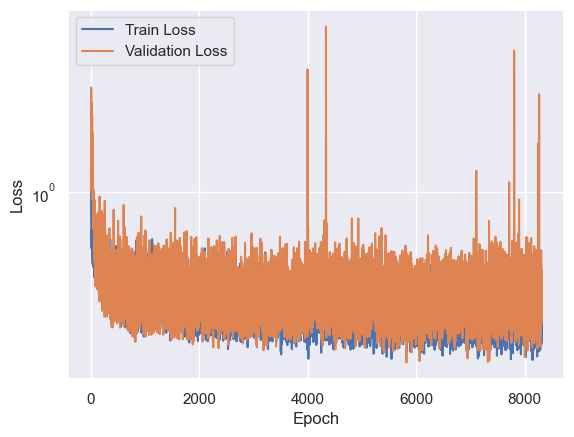

In [18]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [19]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.32446783781051636


In [20]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())

predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)

# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)

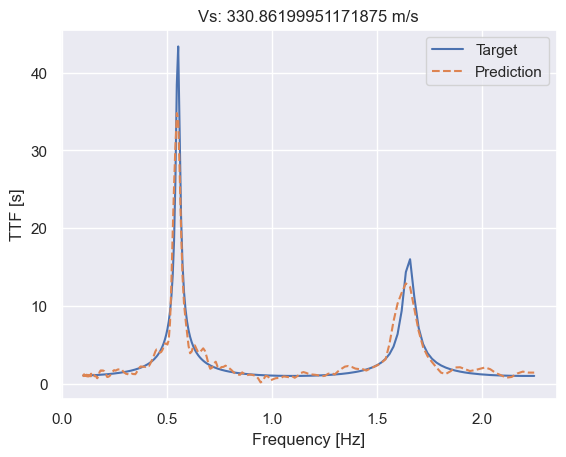

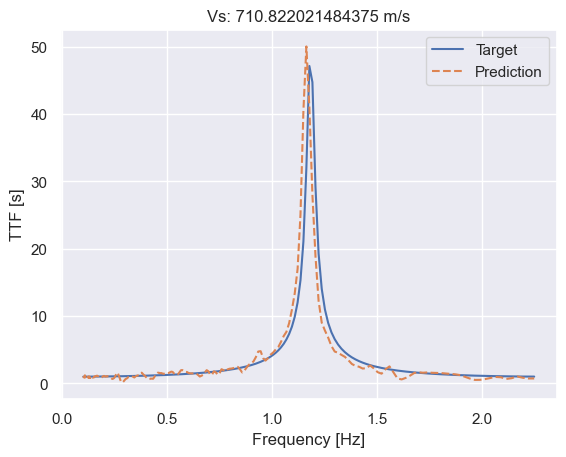

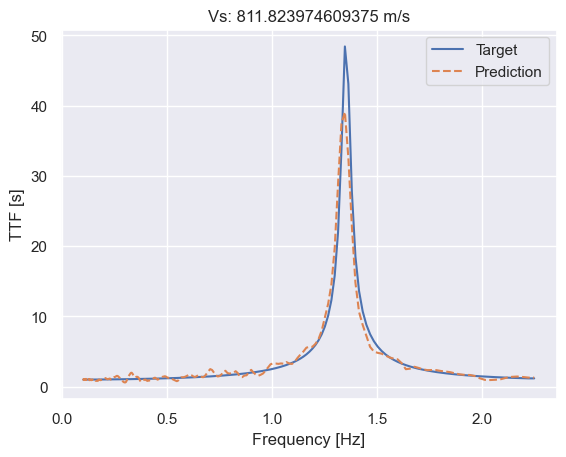

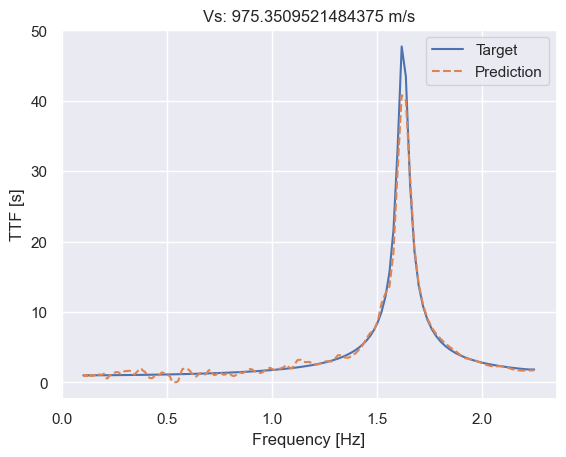

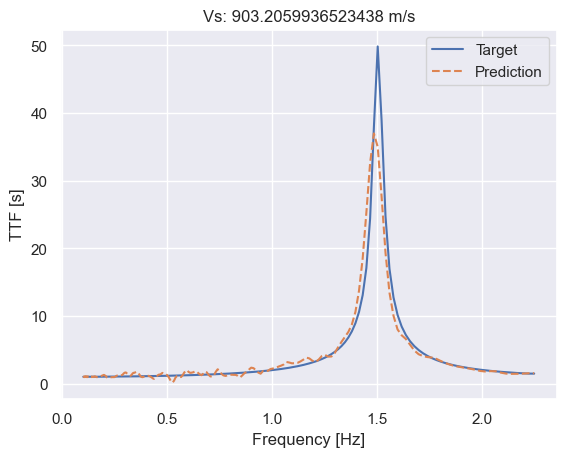

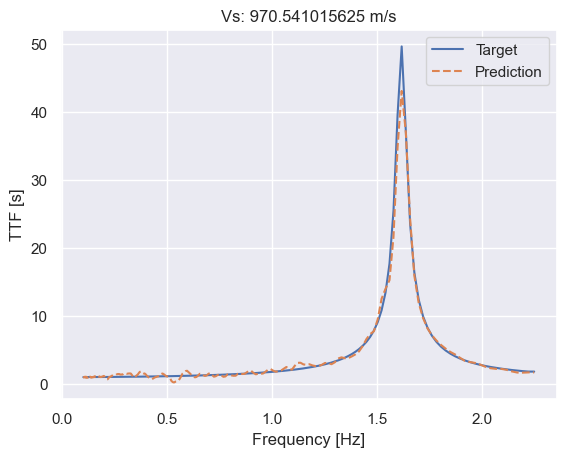

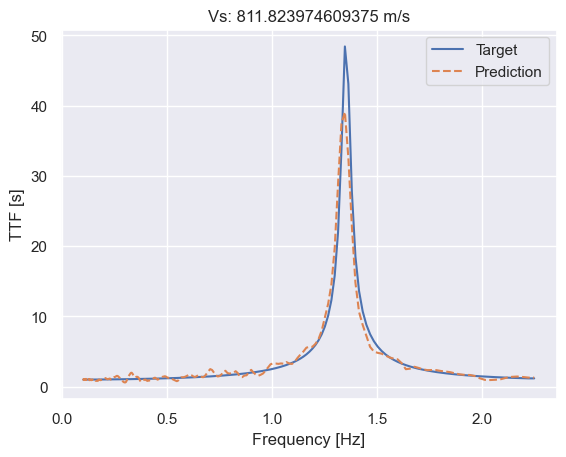

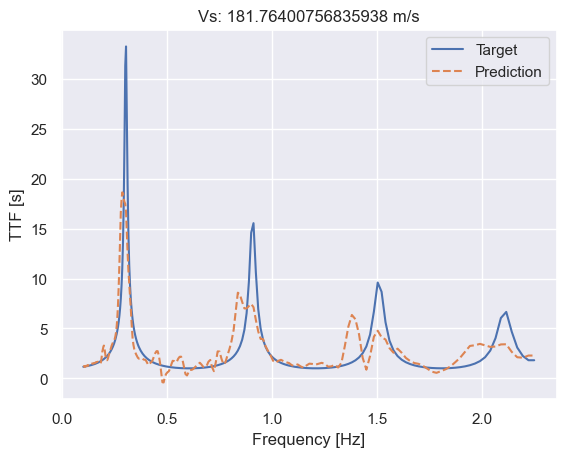

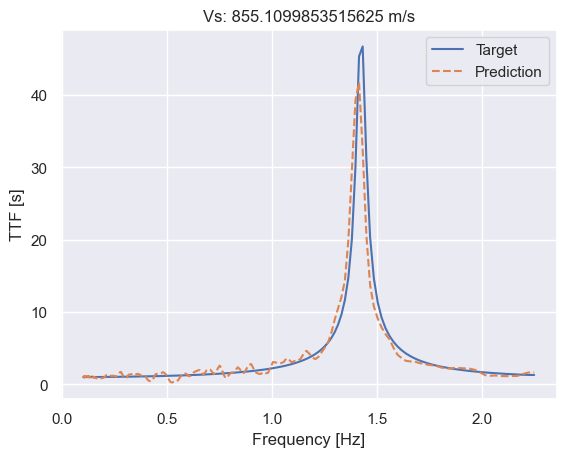

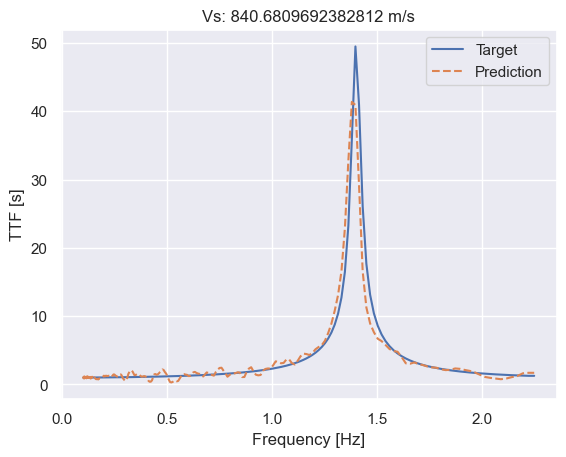

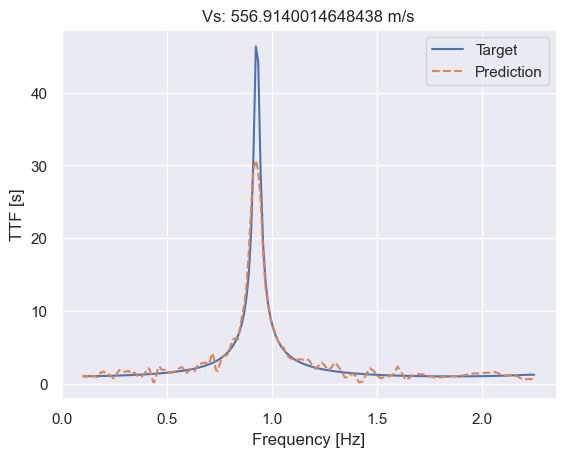

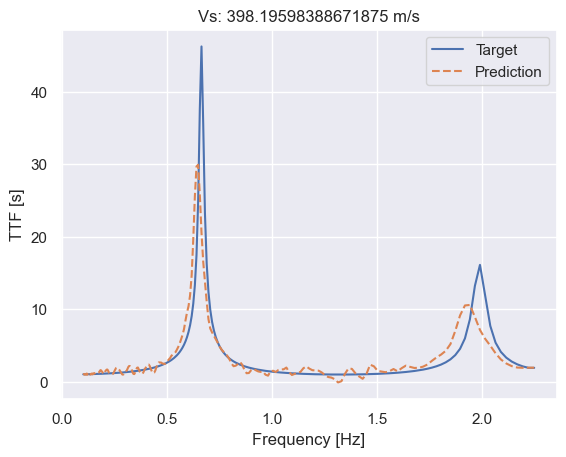

In [21]:
for idx in range(target.shape[0]):
    plt.plot(freq_data,target[idx], label="Target")
    plt.plot(freq_data,predictions[idx], label="Prediction", linestyle="--")
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TTF [s]")
    plt.title(f"Vs: {Vs_target[idx]} m/s")
    plt.show()
    if idx > 10:
        break

In [22]:
# Save model
torch.save(model.state_dict(), "transformer_model.pt")

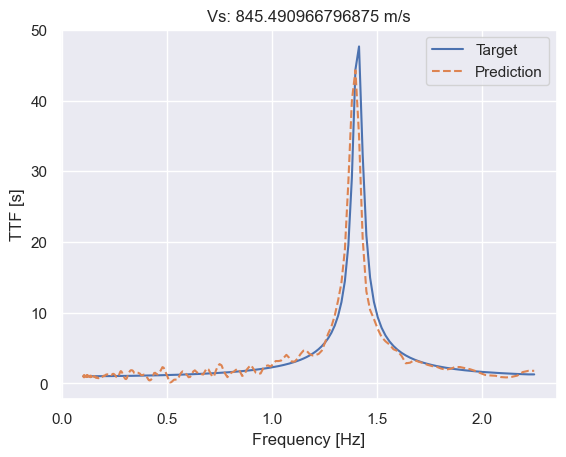

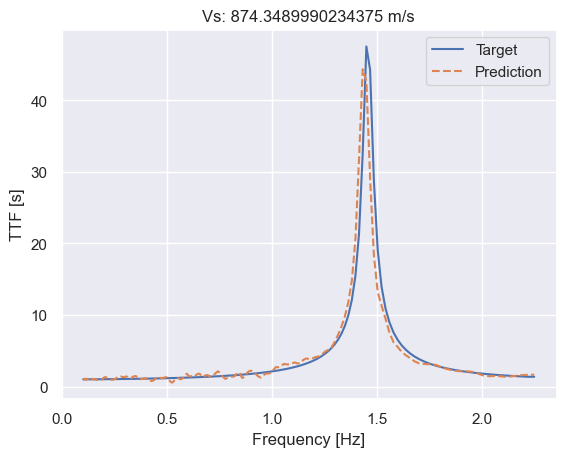

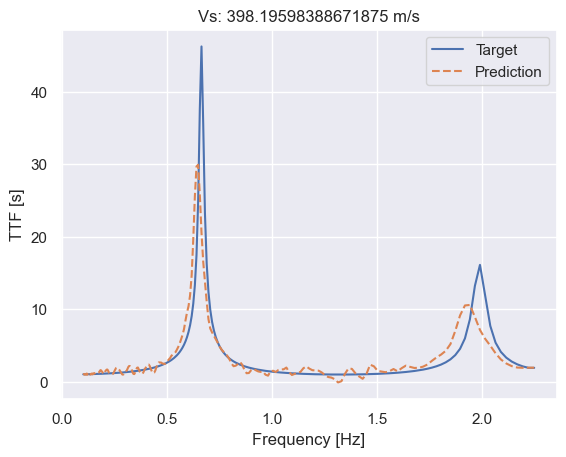

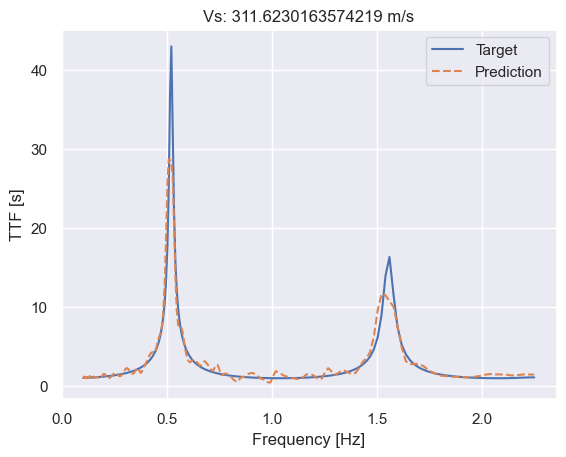

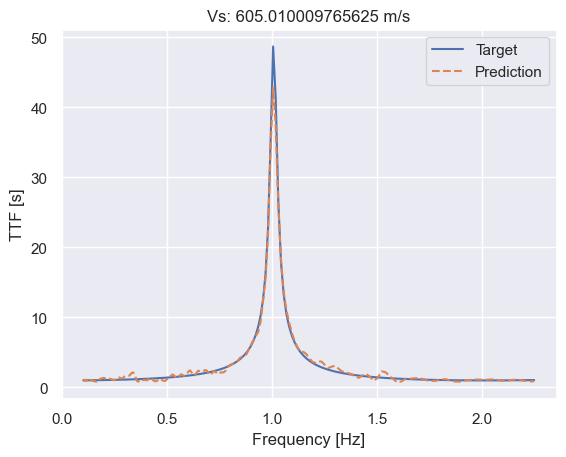

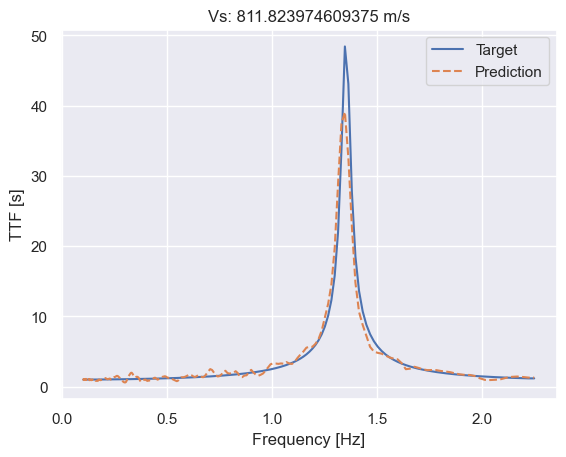

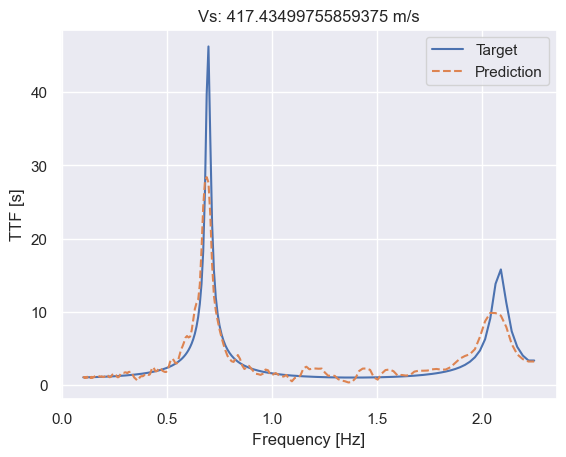

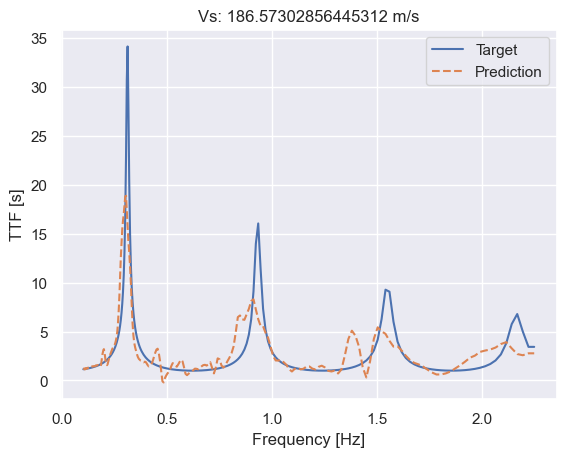

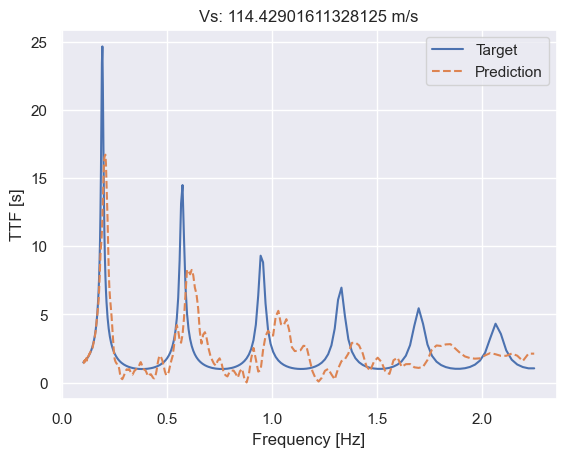

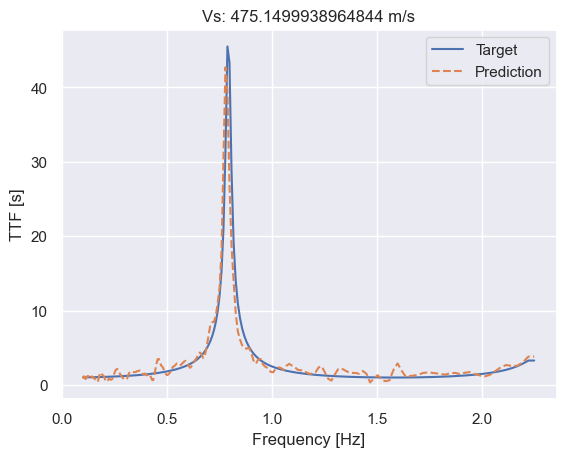

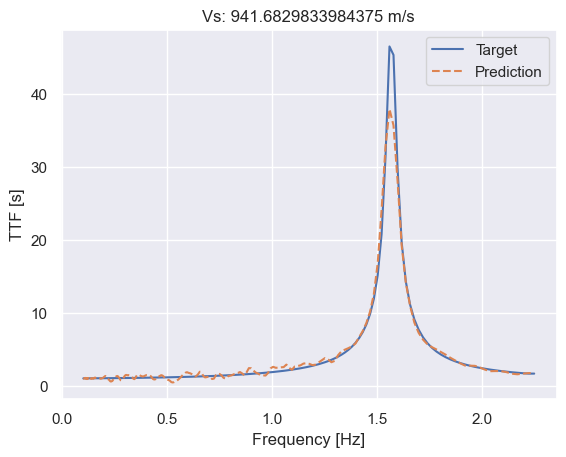

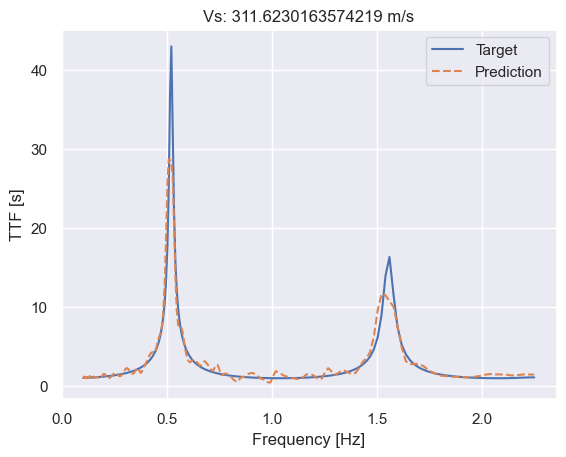

In [23]:
# Load model
model = Transformer(128, 3, 128, 3, 30, 256, 50)
model.load_state_dict(torch.load("transformer_model.pt"))

# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []

with torch.no_grad():
    model.to(device)
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())

predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)

# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)

for idx in range(target.shape[0]):
    plt.plot(freq_data,target[idx], label="Target")
    plt.plot(freq_data,predictions[idx], label="Prediction", linestyle="--")
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TTF [s]")
    plt.title(f"Vs: {Vs_target[idx]} m/s")
    plt.show()
    if idx > 10:
        break